In [23]:
result_path = 'results.pkl'
import pickle

# Open and read the list from the file
with open(result_path, 'rb') as file:
    results = pickle.load(file)

In [24]:
overrun_times_ms = (results[2] - results[0]) / 1e6
labels = results[1]

In [25]:
import numpy as np
assert np.all(np.diff(results[2]) >= 0) # Labelling has been done sequentially
assert np.all(overrun_times_ms <= 50) # Processing took less than 50 ms for each sample

In [26]:
command_samples = [
    [142000, 160000],
    [340000, 360000],
    [620000, 635000]
]

nb_command_samples = sum([elem[1] - elem[0] for elem in command_samples])

In [27]:
import librosa
# Desired sample rate 16000 Hz
sample_rate = 16000

# Frame length
frame_length = 512
# Path to the audio file
audio_file = "test_aaico_challenge.wav"

# Read the audio file and resample it to the desired sample rate
audio_data, current_sample_rate = librosa.load(
    audio_file,
    sr=sample_rate,
)
audio_data_int16 = (audio_data * 32767).astype(np.int16)

number_of_frames = len(audio_data_int16) // frame_length

audio_data_int16 = audio_data_int16[:number_of_frames * frame_length]
audio_duration = len(audio_data_int16) / sample_rate

In [28]:
ground_truth = np.ones(len(audio_data_int16))
for i in range(len(audio_data_int16)):
    if any([i >= e[0] and i <= e[1] for e in command_samples]):
        ground_truth[i] = 0

In [49]:
slow_sample_labelling_thres = 20
command_ratio = nb_command_samples / len(audio_data_int16)
communication_ratio = 1 - nb_command_samples / len(audio_data_int16)

score = len(audio_data_int16)

for i in range(len(audio_data_int16)):
    if overrun_times_ms[i] >= slow_sample_labelling_thres:
        # print("slow")
        score -= 1
    else:
        if ground_truth[i] == 0 and labels[i] != 0: # unintentional broadcast
            score -= int(1 / command_ratio)
        if ground_truth[i] == 1 and labels[i] != 1: # lost communication
            score -= int(1 / communication_ratio)

print(f'Score: {score / len(audio_data_int16)}')

Score: 0.5990720841078067


In [30]:
def custom_score(y_true, y_pred):

    score = len(audio_data_int16)

    for i in range(len(audio_data_int16)):
    
        if y_true[i] == 0 and y_pred[i] != 0: # unintentional broadcast
            score -= int(1 / command_ratio)
        if y_true[i] == 1 and y_pred[i] != 1: # lost communication
            score -= int(1 / communication_ratio)
    return score /len(audio_data_int16)
custom_score(ground_truth, labels)


0.5996031515533723

In [31]:
import pandas as pd
df = pd.read_csv("logdir/debug.csv")
df["label"] = ground_truth
df.head()

,Unnamed: 0,sample_id,label,predscore,time,signal
0,0,0,1.0,0.998362,12.514608,4
1,1,1,1.0,0.998362,12.514608,7
2,2,2,1.0,0.998362,12.514608,5
3,3,3,1.0,0.998362,12.514608,6
4,4,4,1.0,0.998362,12.514608,5


<Axes: >

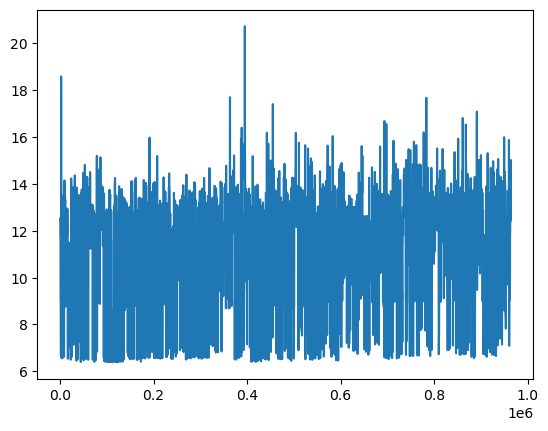

In [32]:
df["time"].plot()

In [45]:
df["prediction"] = df["predscore"].apply(lambda x: 0 if x < 0.27 else 1)

<Axes: >

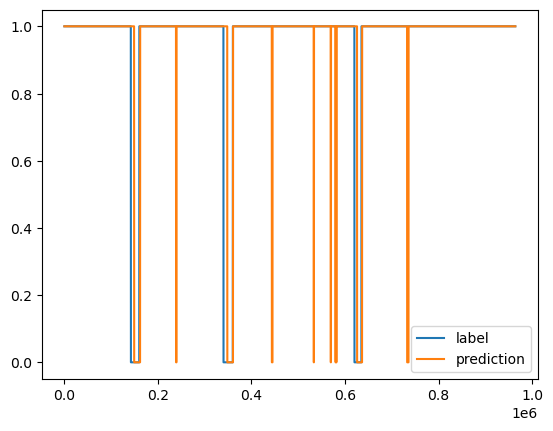

In [46]:
df[["label","prediction"]].plot()

In [35]:
# df[["label","predscore"]].plot()
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def custom_val_score(y_true, y_pred):

    score = len(y_pred)

    for i in range(len(y_pred)):
    
        if y_true[i] == 0 and y_pred[i] != 0: # unintentional broadcast
            score -= int(1 / command_ratio)
        if y_true[i] == 1 and y_pred[i] != 1: # lost communication
            score -= int(1 / communication_ratio)
    return score /len(y_pred)
val_df = df.iloc[:512000]
accuracy = accuracy_score(val_df["label"], val_df["prediction"])
precision = precision_score(val_df["label"], val_df["prediction"])
f1 = f1_score(val_df["label"], val_df["prediction"])
recall = recall_score(val_df["label"], val_df["prediction"])
score = custom_val_score(val_df["label"].values, val_df["prediction"].values)
print(accuracy,precision,f1,recall,score)

0.96003515625 0.9686838624338624 0.9786373060997788 0.988797421086165 0.45694140625


In [48]:
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
# from tqdm import tqdm
# def custom_score(y_true, y_pred):

#     score = len(audio_data_int16)

#     for i in range(len(audio_data_int16)):
    
#         if y_true[i] == 0 and y_pred[i] != 0: # unintentional broadcast
#             score -= int(1 / command_ratio)
#         if y_true[i] == 1 and y_pred[i] != 1: # lost communication
#             score -= int(1 / communication_ratio)
#     return score /len(audio_data_int16)
# resultdf = pd.DataFrame()
# index= 0 
# for threshold in tqdm(range(0,50,1),total=50):
#     threshold = threshold / 100
#     # print(threshold)
#     df["prediction"] = df["predscore"].apply(lambda x: 0 if x < threshold else 1)
#     resultdf.loc[index,"threshold"] = threshold
#     resultdf.loc[index,"accuracy"] = accuracy_score(df["label"], df["prediction"])
#     resultdf.loc[index,"f1"] = f1_score(df["label"], df["prediction"])
#     resultdf.loc[index,"precision"] = precision_score(df["label"], df["prediction"])
#     resultdf.loc[index,"recall"] = recall_score(df["label"], df["prediction"])
#     resultdf.loc[index,"score"] = custom_score(df["label"], df["prediction"])
#     index += 1

    

 12%|█▏        | 6/50 [00:39<04:46,  6.50s/it]


KeyboardInterrupt: 

In [37]:
# resultdf.describe()

In [38]:
# resultdf.sort_values(by="score",ascending=False)

In [39]:
# resultdf.corr()

In [40]:
# len(df)/1883
512*1000

512000

In [41]:
# index= 0 
# resultdf =pd.DataFrame()
# for threshold in tqdm(range(0,60,1),total=60):
#     threshold = threshold / 100
#     # print(threshold)
#     val_df["prediction"] = val_df["predscore"].apply(lambda x: 0 if x < threshold else 1)
#     resultdf.loc[index,"threshold"] = threshold
#     resultdf.loc[index,"accuracy"] = accuracy_score(val_df["label"], val_df["prediction"])
#     resultdf.loc[index,"f1"] = f1_score(val_df["label"], val_df["prediction"])
#     resultdf.loc[index,"precision"] = precision_score(val_df["label"], val_df["prediction"])
#     resultdf.loc[index,"recall"] = recall_score(val_df["label"], val_df["prediction"])
#     resultdf.loc[index,"score"] = custom_val_score(val_df["label"].values, val_df["prediction"].values)
#     index += 1
# resultdf.sort_values(by="score",ascending=False)    

In [42]:
# from soundfile import write
# write("logdir/galacticcommands.wav",val_df[val_df["prediction"]==0]["signal"].values/32767,16000)
# write("logdir/comms.wav",val_df[val_df["prediction"]==1]["signal"].values/32767,16000)

In [43]:
# get start and end index for consecurtive sequences where label ==1



In [44]:
# a = pd.DataFrame({"a":[1,2,3]})
# a["b"] = a["a"].shift(0)
# a

,a,b
0,1,1
1,2,2
2,3,3
